In [17]:
import dill
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import softmax
import pandas as pd
from tqdm import tqdm
from itertools import combinations

In [2]:
folder = "/home/dan/data/connectivity/pyspi_testing/sixrun/calculations/six_run"
files = os.listdir(folder)

pid = 1
pid_files = list(sorted([f for f in files if f.startswith(f"{pid:03}")]))
chnames_idx = pid_files.index(f"{pid:03}_chnames.csv")
chnames = pd.read_csv(os.path.join(folder, pid_files[chnames_idx]))['0'].values
# remove chnames file
pid_files.pop(chnames_idx)

'001_chnames.csv'

In [3]:
results = []
for f in pid_files:
    with open(os.path.join(folder, f, 'calc.pkl'), "rb") as f:
        results.append(dill.load(f))

In [4]:
def transform(x,type):
    if type == "invert":
        # lower values are better; take max and subtract then *-1
        max_values = np.nanmax(x,axis=1)
        max_values = max_values[:, :,np.newaxis]
        return (x -max_values) * -1
    
    if type == "abs":
        return np.abs(x)

In [39]:
def update_elo(r_i, r_j, s_i, s_j, std, K=16):
    # Expected scores
    e_i = 1 / (1 + np.exp((r_j - r_i) / std))
    e_j = 1 - e_i
    
    # Rating updates
    r_i_new = r_i + K * (s_i - e_i)
    r_j_new = r_j + K * (s_j - e_j)
    return r_i_new, r_j_new


def compute_elo(M, initial_rating=1500, K=24):
    std = np.std(M)

    T, C, _ = M.shape
    ratings = np.full((C,C), initial_rating, dtype=float)

    for t in tqdm(range(T)):
        # Go through each row
        for r in range(C):
            combs = list(combinations(range(C), 2))
            # remove comb containing r
            combs = [c for c in combs if r not in c]

            for i, j in combs:
                p_i = M[t, r, i]
                p_j = M[t, r, j]

                # If there's no "match" or it doesn't make sense, you can skip
                if np.isnan(p_i) or np.isnan(p_j):
                    continue

                if p_i > p_j:
                    s_i, s_j = 1.0, 0.0
                elif p_i < p_j:
                    s_i, s_j = 0.0, 1.0
                else:
                    s_i, s_j = 0.5, 0.5
                # Elo partial outcome
                r_i_new, r_j_new = update_elo(ratings[r,i], ratings[r,j],
                                            p_i, p_j, std, K=K)
                ratings[r,i] = r_i_new
                ratings[r,j] = r_j_new

    return ratings


In [35]:

mapping_path = "/media/dan/Big/manuiscript_0001_hfo_rates/data/FULL_composite_patient_info.csv"  
ilae_path = "/media/dan/Big/manuiscript_0001_hfo_rates/ravi_hfo_numbers~N59+v03.csv"
bad_channels_path = "/media/dan/Big/manuiscript_0001_hfo_rates/data/bad_ch_review.xlsx"
edf_path = "/media/dan/Data/data/iEEG/raw_ieeg/baseline_patients/baseline_edfs"
output_path = "/media/dan/Data/git/network_miner/connectivity/output"

pid_source_path = "/media/dan/Big/manuiscript_0001_hfo_rates/ravi_hfo_numbers~N59+v03.csv"


dur_msec = 500
dur_sec = dur_msec / 1000
overlap_msec = 1/2048
overlap_sec = overlap_msec / 1000


# get metadata
mappings = pd.read_csv(mapping_path)
ilae = pd.read_csv(ilae_path)
bad_channels = pd.read_excel(bad_channels_path)
bad_channels["use"] = bad_channels["use"].fillna(1)
bad_channels["use2"] = bad_channels["use2"].fillna(1)
bad_channels["use"] = bad_channels["use"].astype(bool)
bad_channels["use2"] = bad_channels["use2"].astype(bool)

# OR bad_channel columns
bad_channels["bad_channel"] = ~(bad_channels["use"] & bad_channels["use2"])

# for each patient in mappings, find the corresponding ilae number. The patient may not be in the ilae dataset but has a designation of seizureFree or not.
# if the patient is not in the ilae dataset, then use the seizureFree column to determine the ilae number where -1 is seizureFree and 100 is not seizureFree
ilae_numbers = {}
for p in mappings["pid"].unique():
    if p in ilae["patient"].values:
        ilae_numbers[p] = ilae[ilae["patient"] == p]["ilae"].values[0]
    else:
        if mappings[mappings["pid"] == p]["seizureFree"].values[0] == True:
            ilae_numbers[p] = -1
        else:
            ilae_numbers[p] = 100

# now we have a dictionary of ilae numbers for each patient. Fill in the mappings dataframe with these numbers which has multiple rows for each patient
ilae_list = []
for p in mappings["pid"]:
    ilae_list.append(ilae_numbers[p])
mappings["ilae"] = ilae_list


# Perform the merge as before
mappings = mappings.merge(
    bad_channels[['pid', 'ch', 'bad_channel']],
    left_on=['pid', 'electrode'],
    right_on=['pid', 'ch'],
    how='left'
)

# Drop the 'ch' column if needed
mappings = mappings.drop(columns=['ch'])

# Fill NaN values in 'bad_channel' with 0
mappings['bad_channel'] = mappings['bad_channel'].fillna(0)


mappings.loc[(mappings["miccai"].isna() & mappings["aal"].isna()), "bad_channel"] = 1

pid_mappings = mappings[mappings["pid"] == pid]

# remove channels that are not in chnames
pid_mappings = pid_mappings[pid_mappings["electrode"].isin(chnames)]
soz_idx = pid_mappings.index[pid_mappings['soz'] == 1].values

pdist - lower values are better
cohmag - higher values are better
gc - higher values are better
plv - higher values are better
pli - higher values are better
xcorr - higher values are better


xcorr and pli need abs

In [50]:
for col in tqdm(results[0].columns.levels[0].unique()):
    # skip if already processed
    # if os.path.exists(f"{col}.png"):
    #     continue
    if 'pdist' not in col:
        continue
    measure = []
    for r in results:
        measure.append(r[col].values)
    measure = np.array(measure)

    if 'pdist' in col:
        measure = transform(measure, "invert")
    if 'xcorr' in col or 'pli' in col:
        measure = transform(measure, "abs")

    # fill nan with 0
    measure[np.isnan(measure)] = 0
    sm_pdist_euclidean = softmax(measure, axis=1)

    mean_pdist_euclidean = np.mean(measure, axis=0)
    sm_mean_pdist_euclidean = np.mean(sm_pdist_euclidean, axis=0)

    # final_ratings = compute_elo(measure, 1500, 24)

    fig,ax = plt.subplots(1,3, figsize=(20,5))
    sns.heatmap(mean_pdist_euclidean, cmap='nipy_spectral', ax=ax[0])
    sns.heatmap(sm_mean_pdist_euclidean, cmap='nipy_spectral', ax=ax[1])

    # ax[2].plot(final_ratings)

    for idx in soz_idx:
        plt.axvline(x=idx, color='r', linestyle='-', linewidth=.25)

    ax[0].set_title("Mean")
    ax[1].set_title("Softmax")
    ax[2].set_title("ELO")

    # set dashes on x and y on first two axes to soz channels. remove all other axes dashes
    for i in range(2):
        ax[i].set_xticks(soz_idx)
        ax[i].set_xticklabels([])
        ax[i].set_yticks(soz_idx)
        ax[i].set_yticklabels([])


    plt.suptitle(col)
    plt.savefig(f"{col}.png")
    plt.close()
    break

 46%|████▌     | 23/50 [00:00<00:00, 39.33it/s]


In [51]:
M = measure
K = 24
initial_rating = 1500

std = np.std(M)
std = 1

T, C, _ = M.shape
ratings = np.full((C,C), initial_rating, dtype=float)

for t in tqdm(range(T)):
    # Go through each row
    for r in range(C):
        combs = list(combinations(range(C), 2))
        # remove comb containing r
        combs = [c for c in combs if r not in c]

        for i, j in combs:
            p_i = M[t, r, i]
            p_j = M[t, r, j]

            # If there's no "match" or it doesn't make sense, you can skip
            if np.isnan(p_i) or np.isnan(p_j):
                continue

            if p_i > p_j:
                s_i, s_j = 1.0, 0.0
            elif p_i < p_j:
                s_i, s_j = 0.0, 1.0
            else:
                s_i, s_j = 0.5, 0.5
            # Elo partial outcome
            r_i_new, r_j_new = update_elo(ratings[r,i], ratings[r,j],
                                        p_i, p_j, std, K=K)
            ratings[r,i] = r_i_new
            ratings[r,j] = r_j_new

  0%|          | 0/609 [00:00<?, ?it/s]/tmp/ipykernel_28680/2557986987.py:3: RuntimeWarning: overflow encountered in exp
  e_i = 1 / (1 + np.exp((r_j - r_i) / std))
  3%|▎         | 16/609 [01:01<37:53,  3.83s/it]


KeyboardInterrupt: 

In [62]:
mx = np.nanmax(measure[:,0,:])
mi = np.nanmin(measure[:,0,:])

(-7.105427357601002e-15, 37.80750264596959)

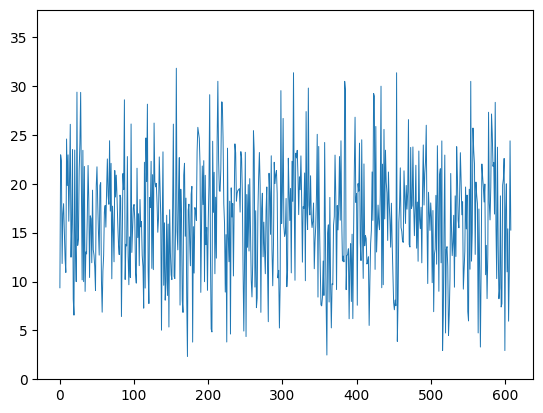

In [91]:
plt.plot(measure[:,0,10], linewidth=.7)
plt.ylim(mi,mx)

(array([  9.,  30.,  69.,  99., 146., 126.,  84.,  38.,   5.,   3.]),
 array([12.81314582, 15.53036742, 18.24758901, 20.9648106 , 23.68203219,
        26.39925379, 29.11647538, 31.83369697, 34.55091857, 37.26814016,
        39.98536175]),
 <BarContainer object of 10 artists>)

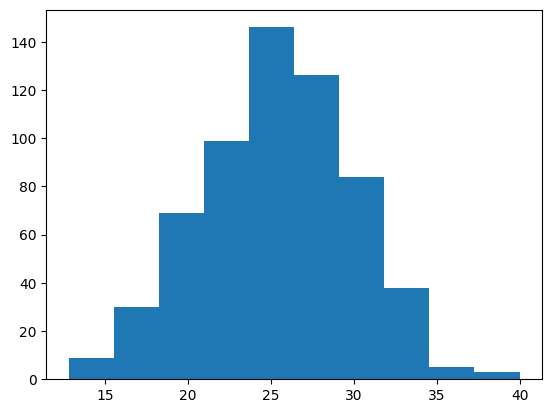

In [57]:
plt.hist(measure[:,1,2])

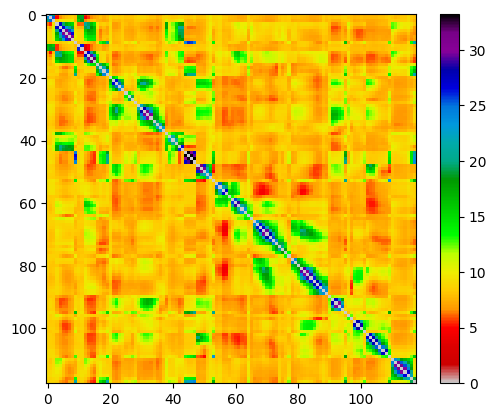

In [80]:
plt.imshow(np.mean(measure,axis=0), cmap='nipy_spectral_r')
plt.colorbar()